# **Early Detection and Risk Prediction for Chronic Diseases**

AAI 510 - 04 (Group 5): Andy Malinsky & Payal Patel

Models: Random Forest Classifier and Logistic Regression

Dataset: CDC Diabetes Health Indicators, https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

# **1. Problem Statement & Justification**

For health insurance companies, wellness programs, and preventive care providers, early identification of individuals at high risk of developing chronic diseases (e.g., diabetes, hypertension, cardiovascular disease) allows for proactive intervention. This translates to reduced healthcare costs, improved patient outcomes, and a better quality of life for individuals, moving from reactive "sick care" to proactive "health care." For this problem, we will focus on diabetes.

Diabetes is a growing health concern that affects million of people worldwide. Not treating this disease may lead to further complications such as heart disease, kidney failure, etc. Early detection is important because it gives people the ability to change their lifestyle or start treatment prior to the disease worsening.

This project aims to build two predictive models (Logistic Regression and Random Forest) that classify individuals as diabetic or non-diabetic using health and demographic indicators from a public dataset. We used logistic regression as a baseline starting point to understand how individual features relate to diabetes risk. Then, we used Random Forest as it handles non-linear relationships, outliers, and imbalanced data well. These types of classification models are useful for better health outcomes as well as reducing the burden on the healthcare system.

# Load Libraries + Dataset

In [1]:
!pip install ucimlrepo
!pip install imblearn

In [2]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, \
 confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Set a global random seed for reproducibility
random_state = 42
np.random.seed(random_state)

# Load dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Target and feature variables
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Combine into one dataframe
df = pd.concat([X, y], axis=1)

# View
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **2. Data Understanding (EDA)**

The CDC Diabetes Health Indicators dataset contains self-reported health and lifestyle factors, including physical and mental health. The target variable, Diabetes_binary, represents whether a patient has diabetes or not.

Class balance:
- 0: No Diabetes
- 1: Diabetes

In [3]:
# Print the shape of the data first
print("Dataset shape : "), df.shape

# Missing data and types
df.info()

# Descriptive stats
df.describe()

Dataset shape : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth         

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


# Target Variable Distribution

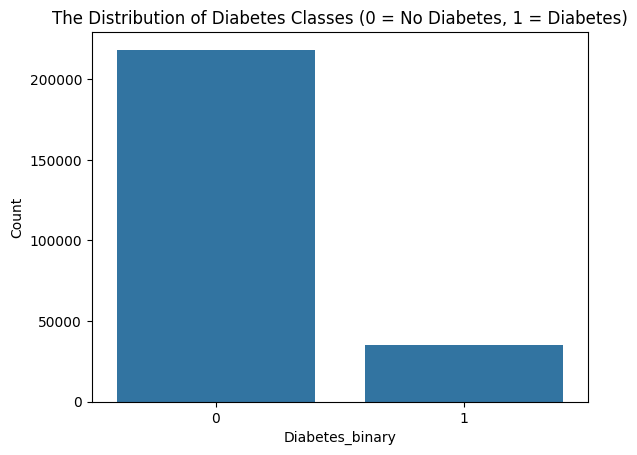

In [4]:
# Class balance
sns.countplot(x='Diabetes_binary', data=df)
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.title('The Distribution of Diabetes Classes (0 = No Diabetes, 1 = Diabetes)')
plt.show()

Based of this graph, we can note that the dataset is imbalanced as majority of the records belong to class 0 - No diabetes. To minimize this, we can consider using a class weight adjustment in our model.

# Correlation Heatmap

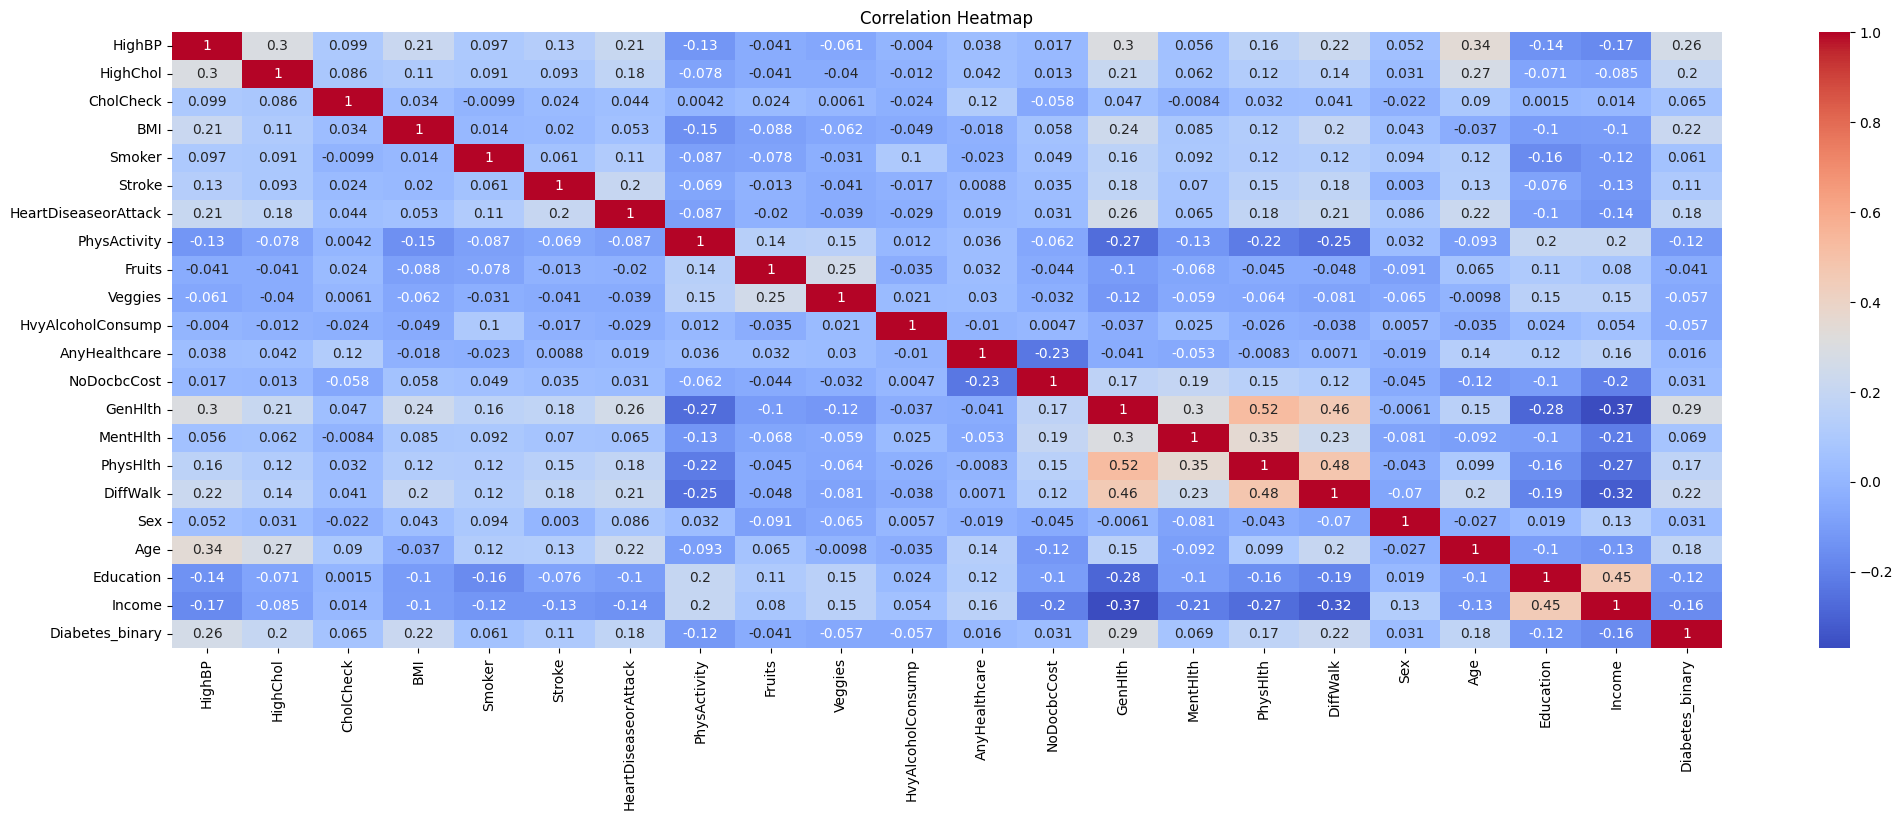

In [5]:
# Correlation heatmap with the target
plt.figure(figsize=(25, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap shows the 'Age', 'GenHlth', 'HighBP', and 'BMI' have positive correlations with diabetes status. Whereas, 'MentHlth' and 'PhysHlth' are correlated with general health, while variables correlated to smoking, diet, and alcohol consumption show weak correlation to diabetes.

# **3. Data Preparation & Feature Engineering**

We will deal with missing values, outliers, etc.

# Check for Missing Values

In [6]:
# Check dataset for missing values
missing_val = df.isnull().sum()
print(missing_val)

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64


We can note that there are no missing values.

# Check for Outliers

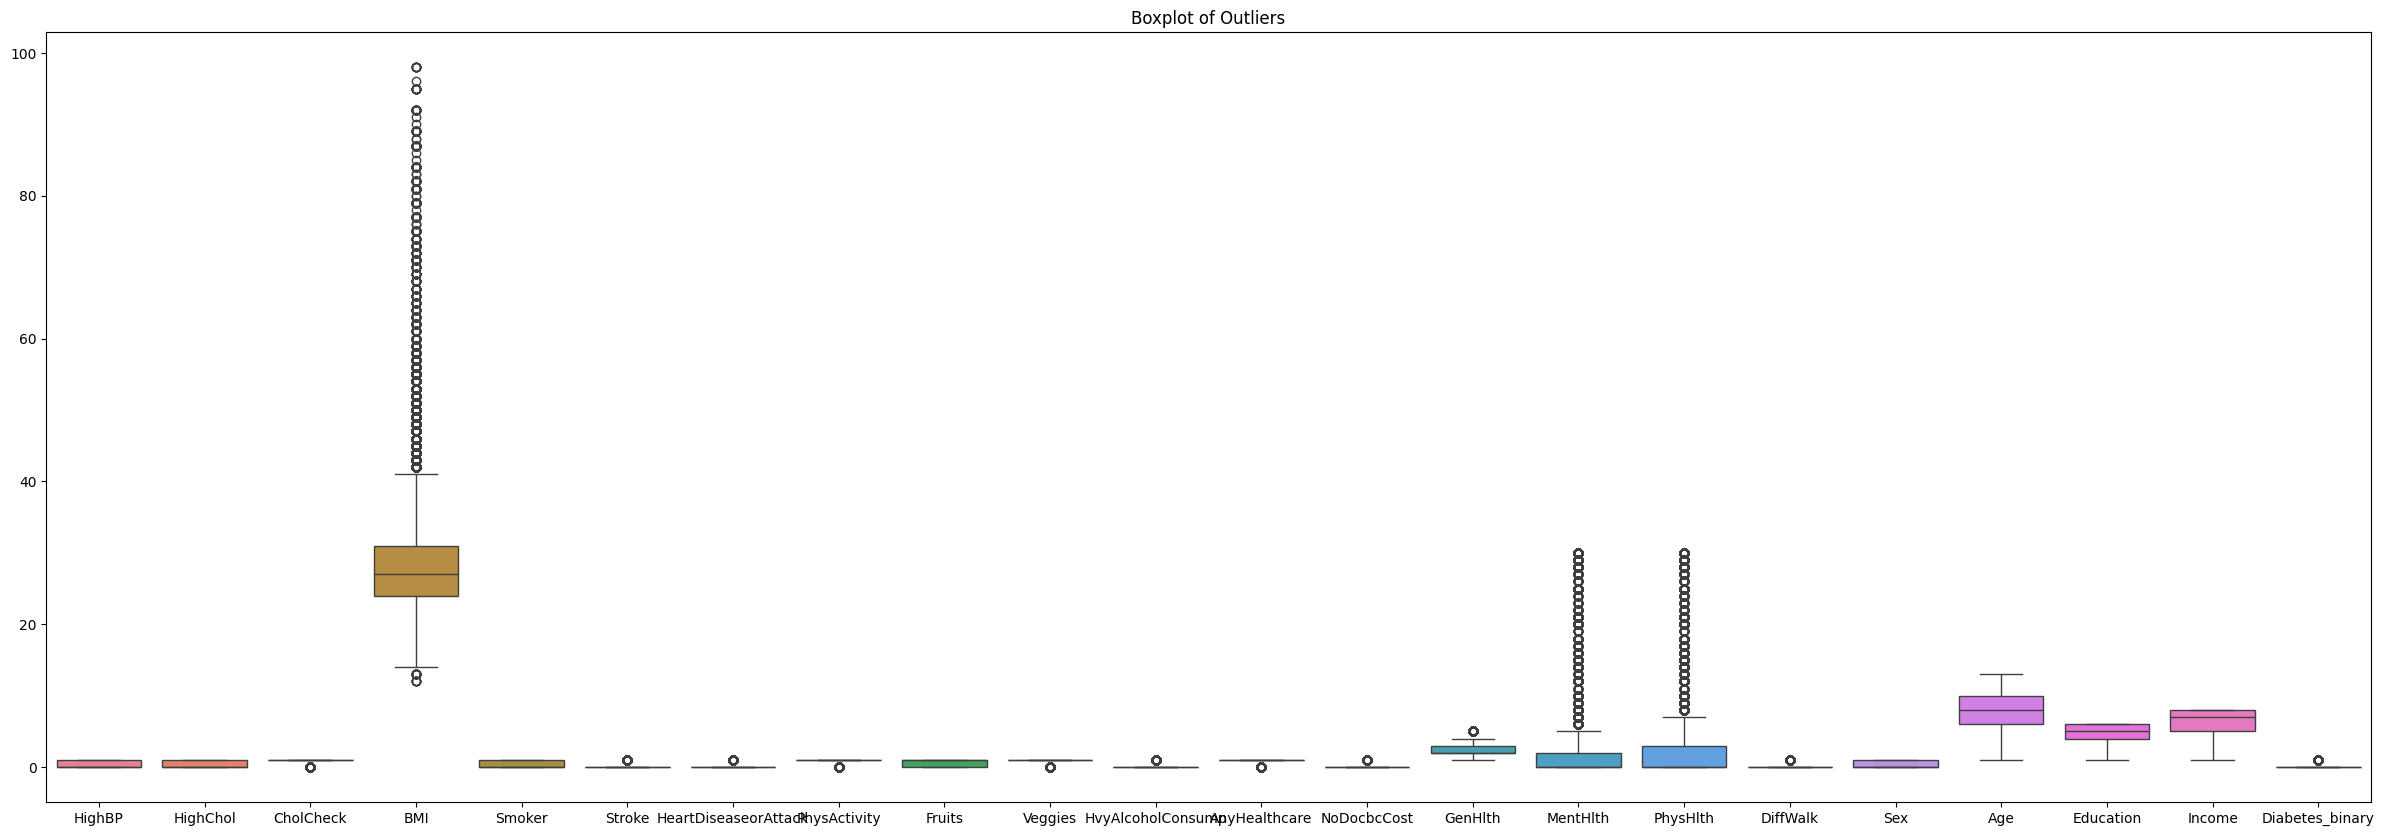

In [7]:
# Check for any outliers
plt.figure(figsize=(30, 10))
sns.boxplot(data=df)
plt.title('Boxplot of Outliers')
plt.show()

In this boxplot, 'BMI' seems to have a significant number of outliers.

Both 'MentHlth' and 'PhysHlth' show outliers, indicating a skewed distribution.

'GenHlth' has minor outliers.

'Age' shows some variability but no outliers.

'Education' and 'Income' do not show meaningful outliers.

Categorical features such as 'HighBP', 'HighChol', 'Smoker', 'Fruits', 'Sex', 'DiffWalk', 'Veggies', etc., do not seem to be meaningful.



# Log Transformation + Winsorize After Log

In [8]:
# Log transformation of the skewed numeric features with outliers
df['BMI'] = np.log1p(df['BMI'])
df['MentHlth'] = np.log1p(df['MentHlth'])
df['PhysHlth'] = np.log1p(df['PhysHlth'])

# Winsorize log transformed columns
df['BMI'] = winsorize(df['BMI'], limits=[0.01, 0.01])
df['MentHlth'] = winsorize(df['MentHlth'], limits=[0.01, 0.01])
df['PhysHlth'] = winsorize(df['PhysHlth'], limits=[0.01, 0.01])

# Drop weak correlated features
df.drop(columns=['Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump'], inplace=True)

# Scale the numeric features
scaler = StandardScaler()

# Numeric columns to scale
col_scale = ['Age', 'Education', 'Income', 'BMI', 'MentHlth', 'PhysHlth']
df[col_scale] = scaler.fit_transform(df[col_scale])

# Check the structure of the columns
print("Structure of the columns:", df.shape)
print("Columns:", df.columns)

Structure of the columns: (253680, 18)
Columns: Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income', 'Diabetes_binary'],
      dtype='object')


We applied log transformation to 'BMI', 'MentHlth', and 'PhysHlth' because these variables were skewed and had extreme outliers. This helped the data become more balanced and easier for the models to understand.

We then used winsorization to limit the extreme values so they do not negatively affect our model.

Addtionally, we removed some features such as 'Smoker', 'Fruits', 'Veggies', and 'HvyAlcoholConsump' because they did not have a strong correlation to diabetes and could add potential noise.

Finally, we scaled the numeric features to help the model treat each feature fairly when making predictions.

# Check for Outlier After Log Transfrom + Winsorizing

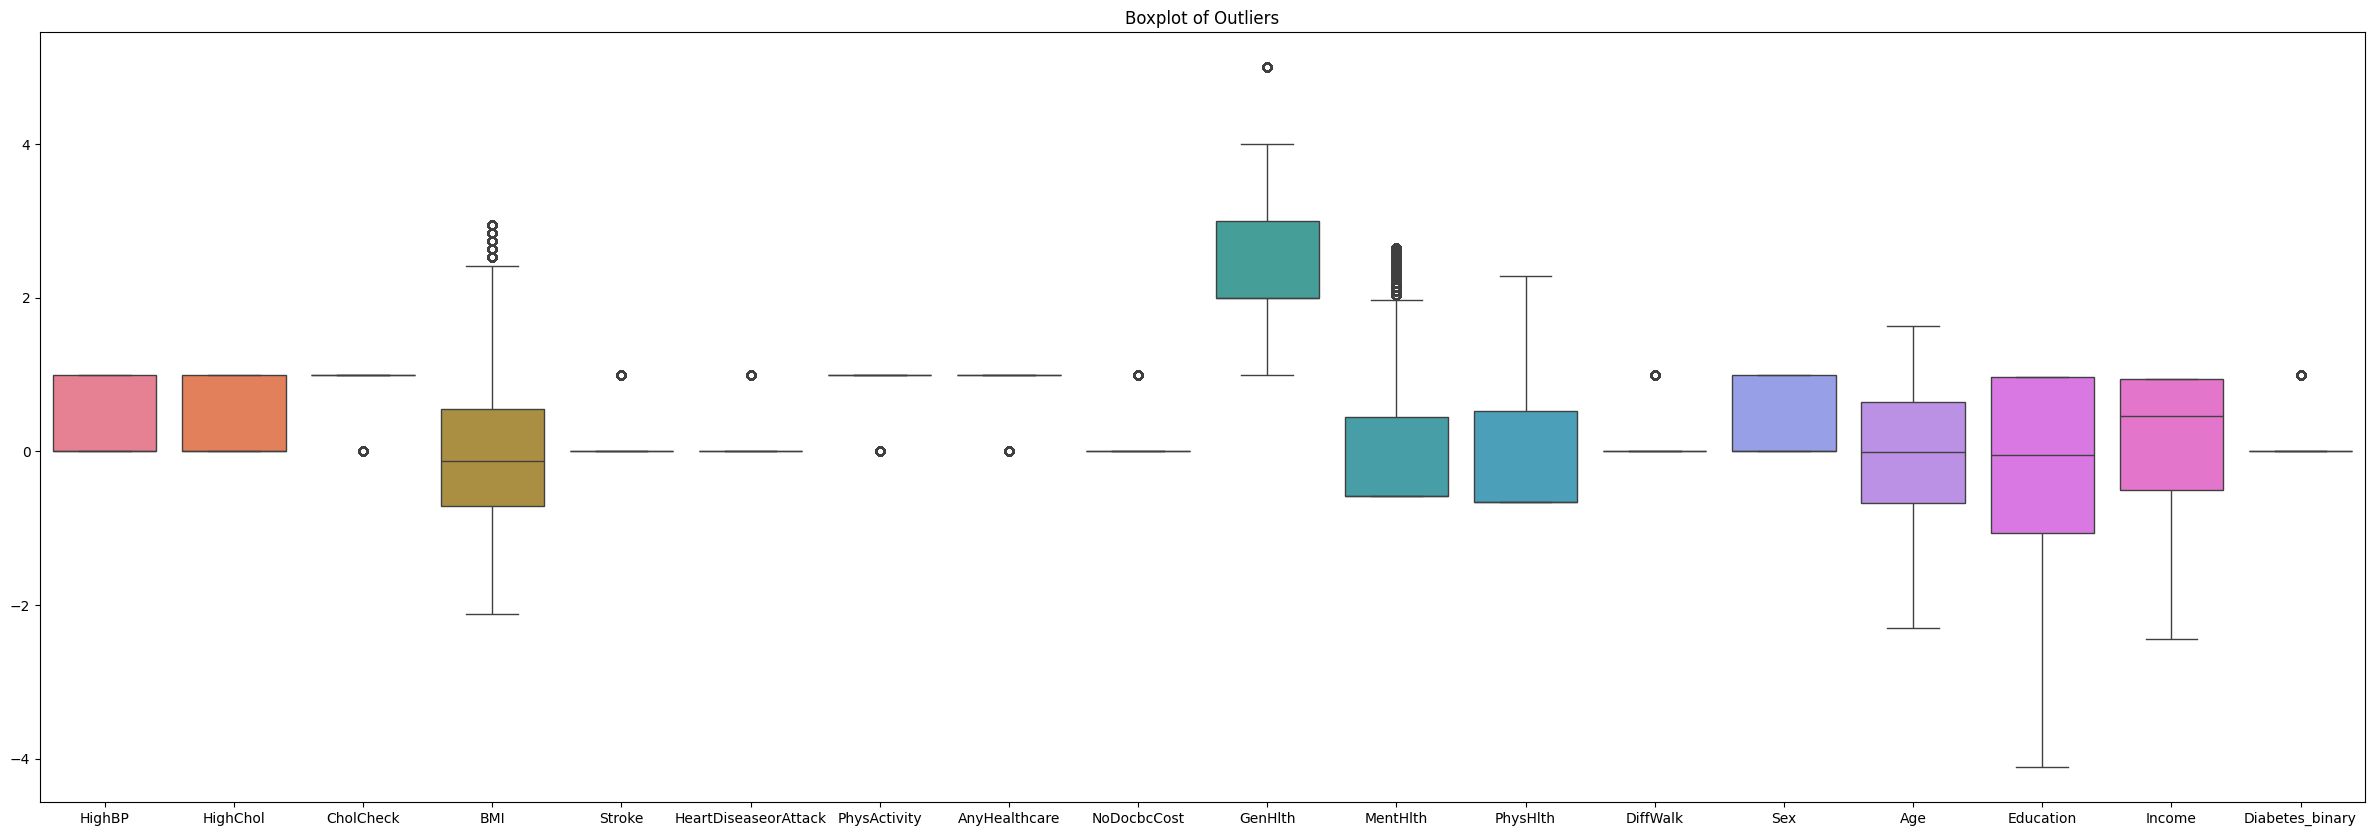

In [9]:
# Plot log transformed/scaled features
plt.figure(figsize=(30, 10))
sns.boxplot(data=df)
plt.title('Boxplot of Outliers')
plt.show()

This boxplot confirms that there are fewer outliers than before.

Since we are using classification models outliers are not a problem as these models are robust to extreme values.

# **4. Feature Selection**

We will test feature correlation and add preference to features that are highly correlated with the target variable and take into account features that are highly correlated with each other. We will calculate Pearson correlations as well as Mutual Information scores to capture both potential linear and non-linear relationships between the features.

In [10]:
# First, we split data into train and test set
target = 'Diabetes_binary'
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
train_df = pd.concat([X_train, y_train], axis=1)

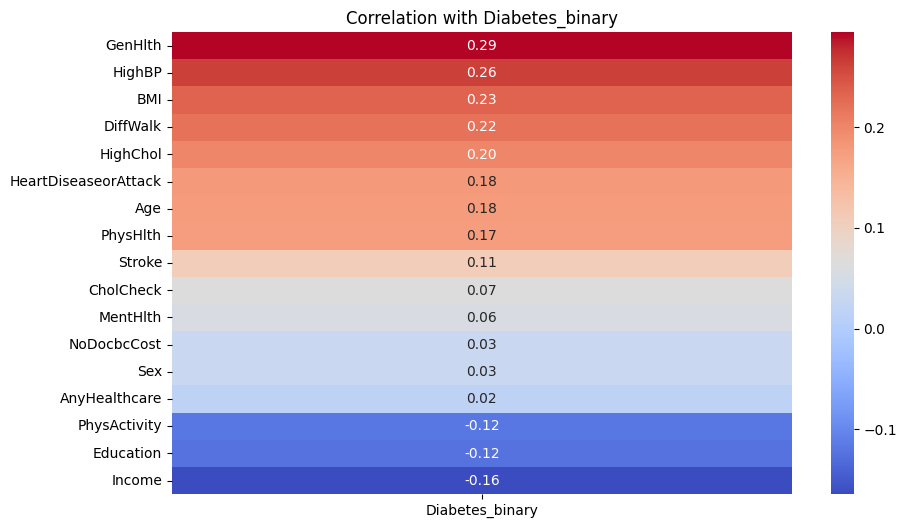

In [11]:
# Calculate the correlation matrix
corr_matrix_train = train_df.corr()

# Extract target variable correlations
target_corr = corr_matrix_train[target].drop(target).sort_values(ascending=False)

# Plot Heatmap of Correlation with Target
plt.figure(figsize=(10, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation with {target}')
plt.show()

The Pearson Correlation (PC) scores capture linear relationships between the feature and the target variable. As shown in the red bars, strong positive correlations indicate that as those features increase the probability of diabetes increases. As shown in the blue bars, strong negative correlations indicate that as those features increase, the probability of diabetes decreases. As shown in the middle gray bars, features with values below 0.10 indicate a very weak to no linear correlation to diabetes.

Features with strong positive correlations (more likely to have diabetes):
*   GenHlth: those with poorer general health (1 = excellent, 5 = poor)
*   HighBP: those with high blood pressure
*   BMI: those with higher body mass index (indicates overwieght/obesity)
*   DiffWalk: those with difficulty walking
*   HighChol: those with high cholesterol
*   HeartDiseaseorAttack: those who have had heart disease or a heart attack
*   Age: those who are older in age
*   PhysHlth: those with poorer physical health (For how many days was your physical health not good? 1-30 days)

Features with strong negative correlations (less likely to have diabetes):
*   PhysActivity: those who engaged in physical activity in the past 30 days
*   Education: those with higher levels of education
*   Income: those with higher income

Features with weak to no linear correlation with diabetes:
*   Stroke: if ever had a stroke
*   CholCheck: if cholesterol was checked in 5 years
*   MentHlth: poor mental health in the past 30 days
*   NoCodbcCost: could not see doctor because of cost
*   Sex: demographic information
*   AnyHealthcare: health insurance status

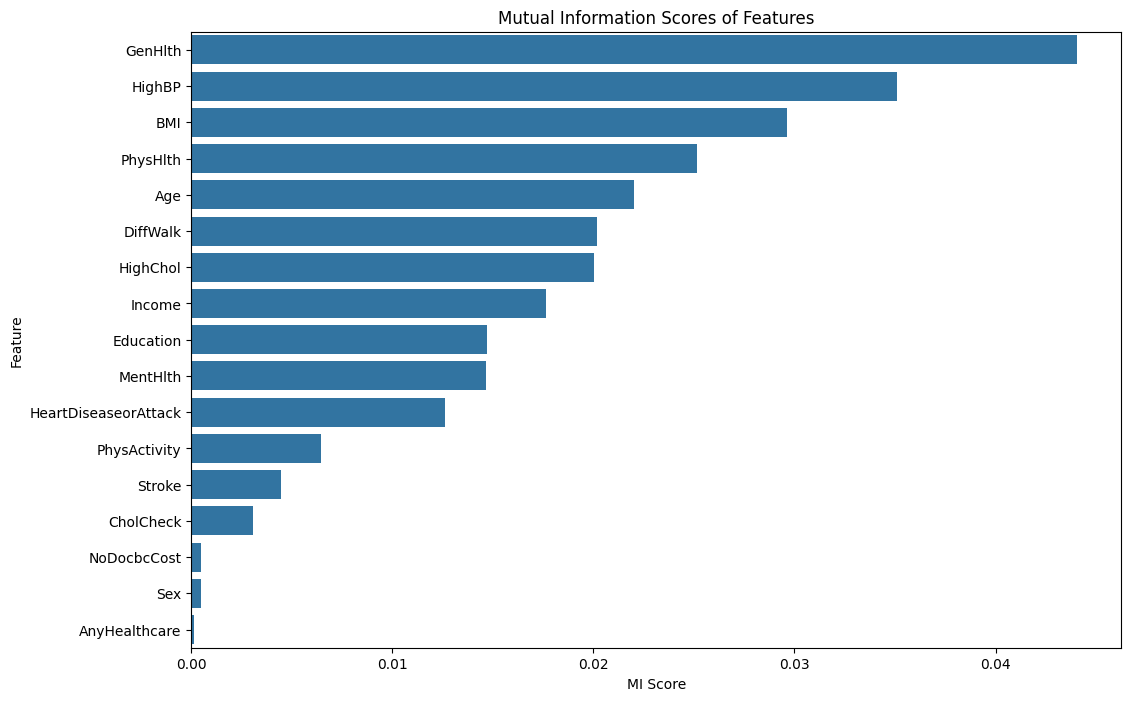

In [12]:
# Calculate Mutual Information Scores

# Identify discrete features for score calculation
df_boolean_mask = [col not in col_scale for col in X_train.columns]

# Estimate mutual information for classification
mi_scores = mutual_info_classif(X_train, y_train.values.ravel(),
                                discrete_features=df_boolean_mask,
                                random_state=random_state)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# Visualize the scores
plt.figure(figsize=(12, 8))
sns.barplot(x=mi_scores, y=mi_scores.index)
plt.title('Mutual Information Scores of Features')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.show()

The Mutual Information (MI) scores measure dependencies between features, and capture both linear and non-linear relationships. Comparing the PC and the MI scores, we can select the most important features in an effort to reduce dimensionality and training efficiency.

Features with both relatively strong PC and MI include GenHlth, HighBP, DiffWalk, BMI, HighChol, Age, PhysHlth, Income, and Education.

Features with relatively strong PC but low MI or strong MI but low PC, include PhysActivity, HeartDiseaseorAttack, and MentHlth.

Features with relatively low PC and MI and strong candidates for removal include Stroke, NoDocbcCost, AnyHealthcare, CholCheck, and Sex.

Overall, features that show strong relevance either linearly or non-linearly will be kept while features with the relatively lowest scores in both PC and MI will be dropped. The selected features are:
*   GenHlth
*   HighBP
*   DiffWalk
*   BMI
*   HighChol
*   Age
*   PhysHlth
*   Income
*   Education
*   PhysActivity
*   HeartDiseaseorAttach
*   MentHlth


In [13]:
# Filter out selected features from training set
selected_features = [
    'GenHlth',
    'HighBP',
    'DiffWalk',
    'BMI',
    'HighChol',
    'Age',
    'PhysHlth',
    'Income',
    'Education',
    'PhysActivity',
    'HeartDiseaseorAttack',
    'MentHlth'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Print Shape Before and After Feature Selection
print("Original X_train shape:", X_train.shape)
print("New X_train_selected shape:", X_train_selected.shape)
print("Original X_test shape:", X_test.shape)
print("New X_test_selected shape:", X_test_selected.shape)

Original X_train shape: (202944, 17)
New X_train_selected shape: (202944, 12)
Original X_test shape: (50736, 17)
New X_test_selected shape: (50736, 12)


From the original dataset, we reduced the number of features from 21 to 12.

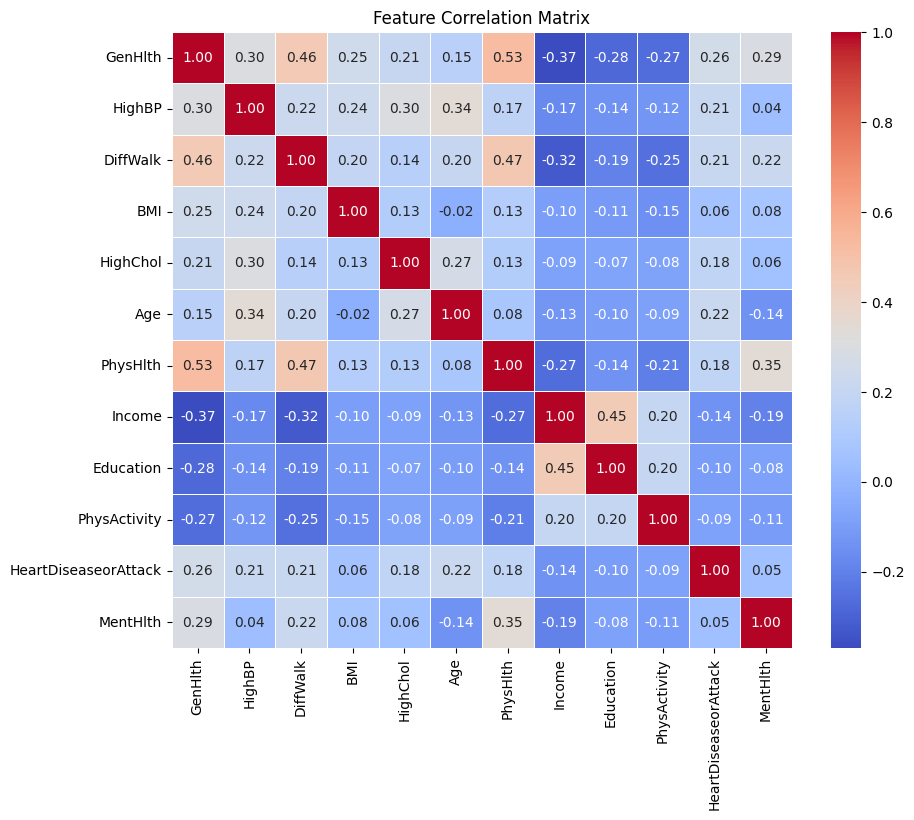

In [14]:
# Plot Heatmap of Selected Feature Correlation
corr_matrix_selected = X_train_selected.corr()
plt.figure(figsize=(10, 8)) # Adjust figure size if needed
sns.heatmap(corr_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

Analyzing the feature correlation matrix, we can see the Pearson correlation coefficient between every pair of the selected features. We can see that no two feature are either highly correlated (> +-0.8) or highly independent (~0).

# Target Class Balancing
Here we try to mitigate the class imbalance by performing Synthetic Minority Over-sampling Technique (SMOTE). To start as a baseline, we increase the samples for target = 1 to match the count of target = 0.

In [15]:
# Oversample minority class
smote = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

print('Target value counts before balancing:\n', y_train.value_counts())
print('\nTarget value counts after balancing:\n', y_train_resampled.value_counts())

Target value counts before balancing:
 Diabetes_binary
0    174667
1     28277
Name: count, dtype: int64

Target value counts after balancing:
 Diabetes_binary
0    174667
1    174667
Name: count, dtype: int64


# **5. Modeling: Logistic Regression**

As a baseline, we train a logistic regression model on the fully resampled SMOTE training data. We chose the 'liblinear' solver as our problem is a binary classification task.

In [16]:
# Train Logisitc Regression (LR) model
lr_model_smote = LogisticRegression(solver='liblinear', max_iter=1000,
                              random_state=random_state).fit(X_train_resampled, y_train_resampled.values.ravel())
lr_model_smote

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [17]:
# Test LR Model with SMOTE
y_pred_smote = lr_model_smote.predict(X_test_selected)
y_pred_proba_smote = lr_model_smote.predict_proba(X_test_selected)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43667
           1       0.31      0.77      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.72      0.76     50736



The logistic regression model with full SMOTE resampling achieved a precision, recall, and f1-score of 0.95, 0.72, and 0.82  on the target class 0, and 0.31, 0.77, and 0.44 on the minority target class 1. This indicates that the model does well in identifying when a sample has no diabetes, but struggles to predict when a sample has diabetes. The false positive rate is 0.31 which is quite low. Based on the recall score of 0.77, it only had a 23% rate of false negatives. It achieved an accuracy of 0.72 and a macro average f1-score of 0.63.This shows that there is still room for improvement.

We will run a grid search to tune some hyperparameters of the model in an attempt to improve model performance. The hyperparameters chosen include ones from the SMOTE object as well as the logistic regression model. From SMOTE, sampling_strategy was chosen to explore different sampling ratios to see if fewer minority samples would result in better generalization. From SMOTE, k_neighbors was chosen to explore the window that generated synthetic samples draw from. For logistic regression, we chose the regularization parameter C to explore which values result in less overfitting. For the grid search, we run cross validation on 3 folds, with the scoring metrics of roc_auc and f1_minority. The roc_auc score gives a measure of how well the model can distinguish the two target classes and f1_minority focuses on the f1-score on the minority class. A high f1-score indicates that the model performs well at identifying minority class and also avoiding false postivies, and exhibits a balance between precision and recall. This is set as the refit metric on the grid search so we select the best performing model based on the highest f1-score on the minority class.

In [18]:
# Define Parameters for GridSearch
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],
    'smote__k_neighbors': [2, 3, 5],
    'lr_model__C': [0.1, 1, 10],
}

# Define scorer for f1-score on minority class
scorer = make_scorer(f1_score, pos_label=1)

lr_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=random_state)
smote = SMOTE(random_state=random_state)
pipeline = Pipeline([('smote', smote), ('lr_model', lr_model)])

# Define GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state),
    scoring=scorer,
    verbose=2
)

print("Starting GridSearchCV fit...")
grid_search.fit(X_train_selected, y_train.values.ravel())
print("GridSearchCV fit complete.")

Starting GridSearchCV fit...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.5; total time=   1.5s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.5; total time=   1.6s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.5; total time=   1.6s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.75; total time=   1.7s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.75; total time=   1.6s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=0.75; total time=   1.8s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=1.0; total time=   1.7s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=1.0; total time=   1.8s
[CV] END lr_model__C=0.1, smote__k_neighbors=2, smote__sampling_strategy=1.0; total time=   1.7s
[CV] END lr_model__C=0.1, smote__k

In [19]:
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-Minority score (validation): {grid_search.best_score_:.4f}")
best_model_lr = grid_search.best_estimator_


--- Hyperparameter Tuning Results ---
Best parameters found: {'lr_model__C': 1, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}
Best F1-Minority score (validation): 0.4556


In [20]:
# Print Classification Report Results for Logistic Regression
y_pred = best_model_lr.predict(X_test_selected)
y_pred_proba = best_model_lr.predict_proba(X_test_selected)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     43667
           1       0.38      0.54      0.45      7069

    accuracy                           0.81     50736
   macro avg       0.65      0.70      0.67     50736
weighted avg       0.85      0.81      0.83     50736



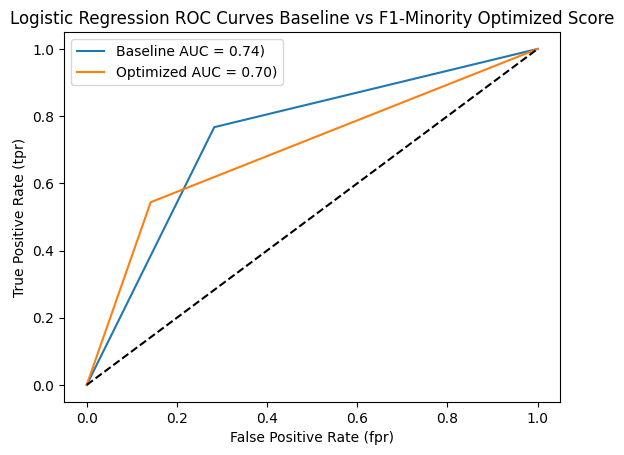

In [21]:
# Plot the ROC curve and AUC Baseline vs F1-Minority Optimized

# Calculate the ROC curve
fpr_1, tpr_1, _ = roc_curve(y_test.values.ravel(), y_pred_smote)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test.values.ravel(), y_pred)
roc_auc_2 = auc(fpr_2, tpr_2)

# Plot the ROC curve
plt.plot(fpr_1, tpr_1, label=f'Baseline AUC = {roc_auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Optimized AUC = {roc_auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Logistic Regression ROC Curves Baseline vs F1-Minority Optimized Score')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend()
plt.show()

Based on the results of the grid search for the logistic regression model, the best parameters found were a regularization C value of 10, a SMOTE k_neighbors value of 2, and a SMOTE sampling_strategy of 0.5. A higher regularization value of 10 was preferred which lead to better generalization and less overfitting. A smaller value of k_neighbors for SMOTE meant that it generated samples within a window of 2 which may indicate that larger k values had too much noise. It was interesting to see that the bets SMOTE sampling_strategy was 0.5. This shows that a 100% minority to majority class matching is not always optimal when optimizing for f1-score on the minority class. The best f1-score on the minority class found was 0.455.

Comparing the baseline to the the optimized model on minority scores, the f1-score only increased from 0.44 to 0.45. Precision increased from 0.30 to 0.38. Recall decreased from 0.76 to 0.54, which means the optimized model has a higher number of false negatives, but recall on the majority class increased from 0.72 to 0.86. Overall accuracy also increased from 0.72 to 0.81. Looking at the ROC curves for both models, the baseline actually had a greater ROC AUC score of 0.74 vs 0.70. This indicates that the slight increase in f1-score on the minority class in the optimized model does not justify the drastic trade-off in recall on the minority class.

Depending on which metric is deemed more important to the use case, the optimized vs the baseline model may be the better choice. If minimizing false positives is more important, the optimized has higher precision. If minimizing false negatives is more important, the baseline has higher recall. In the domain of chronic disease prediction and prevention, recall is arguably the more important metric as missing actual diagnoses can have sever health impacts if conditions go unidentified for a long time. Therefore the baseline model should be used in future predictions. Some future areas for improvement are exploring more class balancing methods, feature engineering, and threshold tuning.

# **6. Modeling: Random Forest Classifier**

In [22]:
# Selected features
selected_features = [
    'GenHlth',
    'HighBP',
    'DiffWalk',
    'BMI',
    'HighChol',
    'Age',
    'PhysHlth',
    'Income',
    'Education',
    'PhysActivity',
    'HeartDiseaseorAttack',
    'MentHlth'
]

# Feature selection
X = df[selected_features]
y = df['Diabetes_binary']

In [23]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y)

In [24]:
# Random forest with class_weight and parameters
random_forest = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5,
                                       min_samples_leaf=2, max_features='sqrt', class_weight='balanced', random_state=random_state)
random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [25]:
# Make predictions
y_pred = random_forest.predict(X_test)
y_prob = random_forest.predict_proba(X_test)[:, 1]

# Print metrics
print(" ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 4))
print("\n Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n Classification:\n", classification_report(y_test, y_pred))

 ROC AUC Score: 0.8012

 Accuracy: 0.8098

 Classification:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89     43667
           1       0.37      0.49      0.42      7069

    accuracy                           0.81     50736
   macro avg       0.64      0.68      0.65     50736
weighted avg       0.84      0.81      0.82     50736



The Random Forest model achieved a ROC AUC score of 0.80 and an overall accuracy of 81% suggesting that the model is able to distinguish between individuals with and without diabetes.

While the precision for the positive class (diabetes) is 0.37, the recall of 0.50 indicates that the model identifies half of the true diabetes cases, which is extremely important for early detection in a healthcare setting.

Overall, the model's performance is good for risk screening and can be improved with other modeling techniques such as XGBoost.

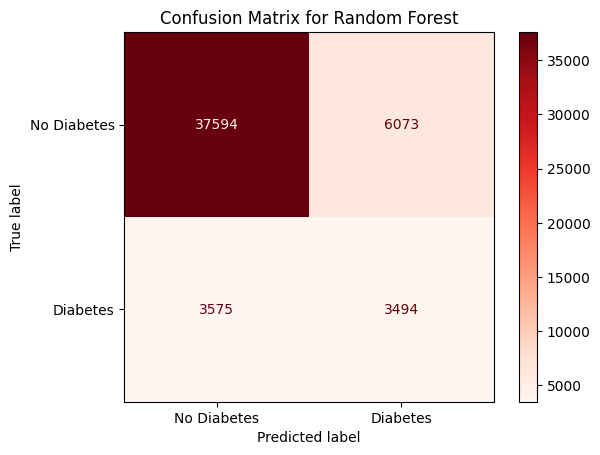

In [26]:
# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)

# Plot
plot_cm = ConfusionMatrixDisplay(confusion_matrix=c_matrix,
                              display_labels=['No Diabetes', 'Diabetes'])

plot_cm.plot(cmap='Reds')
plt.title("Confusion Matrix for Random Forest")
plt.show()

The confusion matrix above evaluates the performance of the Random Forest classifier on the diabetes dataset. The matrix highlights that while the model is effective at identifying patient without diabetes, it struggles with accurately identifying patients with diabetes.

The breakdown is as follows:
- True Negatives (No Diabetes correctly classified): 37,549.
- False Positives (No Diabetes incorrectly classified as Diabetes): 6,118.
- False Negatives (Diabetes incorrectly classified as No Diabetes): 3530.
- True Positives (Diabetes correctly classified): 3,539.

Nonetheless, the model seems to maintains a balanced performance.

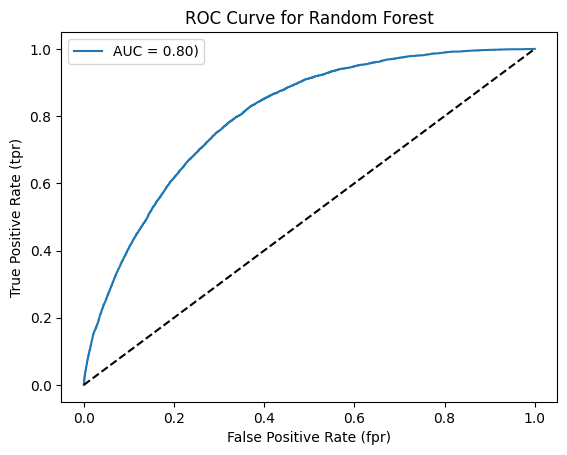

In [27]:
# Plot the ROC curve and AUC

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Random Forest')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend()
plt.show()

The ROC (Receiver Operating Characteristic) curve shows how well the model separates the two classes (Diabetes vs. No Diabetes) at different thresholds. The AUC (Area Under the Curve) is 0.80, which suggests that the model does a good job overall at distinguishing between patients with and without diabetes. Any AUC value close to 1 indicates better performance.

# **7. Model Comparison**
Here we compare the logistic regression model to the random forest model to see which is the better classifier. For logistic regression, we use the baseline model trained with 100% SMOTE.

In [28]:
# Logistic Regression
pred_log = lr_model_smote.predict(X_test)
prob_log = lr_model_smote.predict_proba(X_test)[:, 1]

# Random Forest
pred_rf = random_forest.predict(X_test)
prob_rf = random_forest.predict_proba(X_test)[:, 1]

In [29]:
# LR metrics
l_acc = accuracy_score(y_test, pred_log)
l_prec = precision_score(y_test, pred_log)
l_f1 = f1_score(y_test, pred_log)
l_auc = roc_auc_score(y_test, prob_log)
l_recall = recall_score(y_test, pred_log)

# RF metrics
rf_acc = accuracy_score(y_test, pred_rf)
rf_prec = precision_score(y_test, pred_rf)
rf_f1 = f1_score(y_test, pred_rf)
rf_auc = roc_auc_score(y_test, prob_rf)
rf_recall = recall_score(y_test, pred_rf)

In [30]:
compare = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC-AUC','F1 Score'],
    'Random Forest': [rf_acc, rf_prec, rf_recall, rf_f1, rf_auc],
    'Logistic Regression': [l_acc, l_prec, l_recall, l_f1, l_auc]})

compare = compare.round(4)
compare

,Metric,Random Forest,Logistic Regression
0,Accuracy,0.8098,0.7241
1,Precision,0.3652,0.3051
2,Recall,0.4943,0.7672
3,ROC-AUC,0.4201,0.4366
4,F1 Score,0.8012,0.8162


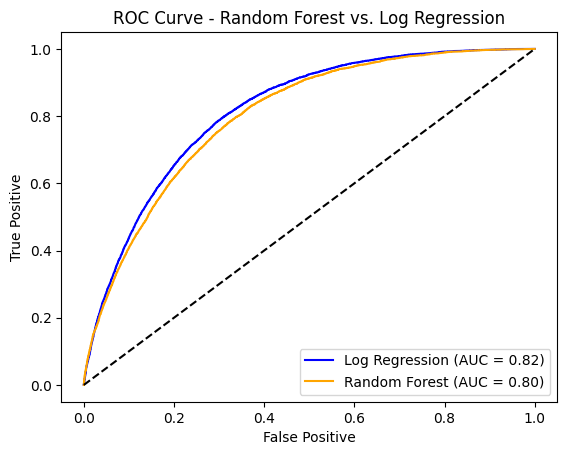

In [31]:
# ROC
fpr_l, tpr_l, _ = roc_curve(y_test, prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf)

# AUC
auc_l = auc(fpr_l, tpr_l)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.plot(fpr_l, tpr_l, label=f'Log Regression (AUC = {auc_l:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve - Random Forest vs. Log Regression')
plt.legend()
plt.show()

Logistic Regression vs. Random Forest:

While Random Forest showed a higher accuracy (81%) and precision (37%), it struggled to correctly identify positive cases, with a lower recall (49%). This means it missed the majority of individuals who presented with diabetes.

The Logistic Regression model has a lower accuracy (72%) and precision (31%), but a significantly higher recall (77%). Logistic regression had slightly higher ROC-AUC (.44 vs .42) and f1-score (82% vs 80%). This suggests a better balance between identifying diabetes cases and avoiding false positives.

Overall, though Random Forest is more accurate, in this case Logistic Regression meets the business objective of indentifying patients at a risk for diabetes. We believe that in a healthcare setting, recall is far more important than precision, as failing to detect diabetes could lead to additional diseases overtime. Therefore, in this experiment, the Logistic Regression model would be an appropriate choice.

# **8. Deployment Discussion**

Though these models have not been deployed into the healthcare system, we can make predictions based on how it could be used in a public setting. The Logistic Regression model can be used in a electronic health record system to automatically assess if a patient is at a risk of diabetes based on a given response to a health questionnaire.

For instance, when a patient fills out a lifestyle questionnaire such as BMI, physical activity, mental health, etc., the model would be able to generate a score. If it exceeds a threshold then the system would flag that specific patient to follow up with further medical attention.

Additionally, to follow health standards, it is important to monitor the model over time to see its performance, ensure patient information stays confidential, and remember that the model is like an assistant, not a replacement for human decision making.

# **9. Discussion & Conclusion**

The goal of this project was to build a model that can help identify individuals at risk for diabetes using health and lifestyle data. After exploring two models, the Logistic Regression classifier was selected as an ideal approach for its better recall score in comparison to the Random Forest model.

While the Random Forest model achieved a higher precision and accuracy, it failed to detect most positive diabetes cases. Logistic Regression seemed to have a better balance, achieving a recall of 77% and an F1 score of 81%.

The model used 12 key features selected based on exploratory analysis. Numeric features were log transformed, winsorized, and scaled to reduce outliers and skew. These preprocessing steps helped improve the model performance.

In conclusion, the final Logistic Regression model is an appropriate approach for an early detection of diabetes. This model can be used with the support of healthcare professional during regular checks to reduce undiagnosed cases.